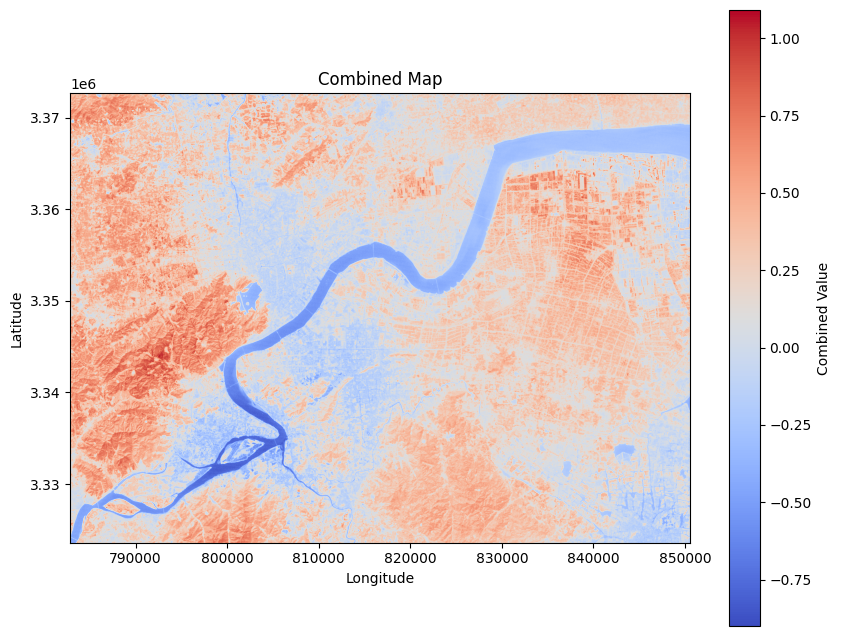

In [2]:
from osgeo import gdal
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from shapely import geometry
from osgeo import osr

# 导入AQI数据
aqi_data = pd.read_csv('D:/GitHub/杭州市绿色生活出行系统/src/result/aqi_data.csv', encoding='gbk')

# 导入NDVI数据
ndvi_dataset = gdal.Open('result/ndvi.tiff')
ndvi_array = ndvi_dataset.ReadAsArray()

# 获取NDVI数据的地理变换信息
geotransform = ndvi_dataset.GetGeoTransform()
projection = ndvi_dataset.GetProjection()
x_min = geotransform[0]
y_max = geotransform[3]
pixel_width = geotransform[1]
pixel_height = geotransform[5]
x_max = x_min + pixel_width * ndvi_array.shape[1]
y_min = y_max + pixel_height * ndvi_array.shape[0]
aqi_data = aqi_data[aqi_data['AQI'] != '-']
# 进行反距离权重差值
# 定义插值网格的空间分辨率
grid_resolution = 30

# 创建插值网格的坐标
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, grid_resolution),
                             np.arange(y_min, y_max, grid_resolution))

# 获取插值所需的坐标和AQI值
points = aqi_data['geometry'].apply(lambda x: eval(x)[::-1]).tolist()


values = aqi_data['AQI'].values

# 创建源坐标系和目标坐标系对象
source_srs = osr.SpatialReference()
target_srs = osr.SpatialReference()

# 设置源坐标系和目标坐标系的坐标系类型和投影信息
source_srs.ImportFromEPSG(4326)  # 假设AQI数据使用WGS84经纬度坐标系
target_srs.ImportFromWkt(projection)  # 使用NDVI数据的投影信息

# 创建坐标转换对象
transform = osr.CoordinateTransformation(source_srs, target_srs)

# 转换AQI数据的坐标
transformed_points = []
for point in aqi_data['geometry']:
    lon, lat = eval(point)
    transformed_point = transform.TransformPoint(lon, lat)
    transformed_points.append(transformed_point[:2])

# 将转换后的坐标作为新的points
points = np.array(transformed_points)

# 创建四个角点的坐标和数值
corner_points = np.array([[x_min, y_min],  # 左上角
                         [x_max, y_min],  # 右上角
                         [x_min, y_max],  # 左下角
                         [x_max, y_max]]) # 右下角

# 替换为平均值和浮动值的角点数值
mean_value = np.mean(values.astype(float))

delta = 20;

corner_values = np.array([values[1],
                         values[8],
                         values[7],
                         mean_value + delta/2])


# 合并原始观测点和角点的坐标和数值
points = np.concatenate((points, corner_points), axis=0)
values = np.concatenate((values, corner_values), axis=0)

# 进行逆距离加权插值
aqi_interpolated = griddata(points, values, (x_grid, y_grid), method='cubic')

import matplotlib.pyplot as plt
# 归一化AQI数据
aqi_normalized = (aqi_interpolated ) / np.nanmax(aqi_interpolated)

# 归一化NDVI数据
ndvi_normalized = (ndvi_array - np.nanmin(ndvi_array)) /np.nanmax(ndvi_array)

# 将归一化后的AQI数据和NDVI数据加和
combined_data = ndvi_normalized - aqi_normalized

# 绘制合并后的数据
plt.figure(figsize=(10, 8))
plt.title('Combined Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.imshow(combined_data, extent=[x_min, x_max, y_min, y_max], origin='upper', cmap='coolwarm')
plt.colorbar(label='Combined Value')
plt.show()


# 创建GDAL驱动程序
driver = gdal.GetDriverByName('GTiff')

# 获取NDVI数据集的行数和列数
rows = ndvi_array.shape[0]
cols = ndvi_array.shape[1]

# 创建新的GeoTIFF数据集
dst_dataset = driver.Create('D:/GitHub/杭州市绿色生活出行系统/src/result/combined_data.tif', cols, rows, 1, gdal.GDT_Float32)

# 获取NDVI数据集的地理变换信息
dst_dataset.SetGeoTransform(geotransform)
dst_dataset.SetProjection(projection)

# 将combined_data写入GeoTIFF数据集
band = dst_dataset.GetRasterBand(1)
band.WriteArray(combined_data)


# 关闭数据集
dst_dataset = None

